# 4 Construct the Training set data-balanced RAFDB dataset 
# (for object detection)

### This section focuses on solving the data imbalance problem of RAF-DB.
#### Using In the following code block, multiple data augmentation methods are applied to the segmented RAF-DB-Detection dataset using a variety of data augmentation methods to achieve data balancing only for the training set set.The RAF-DB-Detection dataset is obtained from file 1.

In [17]:
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
import albumentations as A

emotions = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']
TARGET_COUNT = 7325
IMAGE_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/train/images'
LABEL_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/train/labels'
AUGMENTED_IMAGE_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_train_balance/train/images'
AUGMENTED_LABEL_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_train_balance/train/labels'


os.makedirs(AUGMENTED_IMAGE_DIR, exist_ok=True)
os.makedirs(AUGMENTED_LABEL_DIR, exist_ok=True)
image_files = glob(os.path.join(IMAGE_DIR, '*.jpg'))
label_files = glob(os.path.join(LABEL_DIR, '*.txt'))
category_counts = {emotion: 0 for emotion in emotions}
single_category_files = {emotion: [] for emotion in emotions}

for label_file in label_files:
    with open(label_file, 'r') as file:
        lines = file.readlines()
        if len(lines) == 1:
            category_idx = int(lines[0].split()[0])
            category = emotions[category_idx]
            image_file = label_file.replace(LABEL_DIR, IMAGE_DIR).replace('.txt', '.jpg')
            single_category_files[category].append((image_file, label_file))
        for line in lines:
            category_idx = int(line.split()[0])
            category = emotions[category_idx]
            category_counts[category] += 1

print("Initial category counts:")
for category, count in category_counts.items():
    print(f"{category}: {count} instances")

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Rotate(limit=(5,10), p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5) 
])

for image_file in image_files:
    shutil.copy(image_file, AUGMENTED_IMAGE_DIR)

for label_file in label_files:
    shutil.copy(label_file, AUGMENTED_LABEL_DIR)
total_augmentations_needed = sum(max(0, TARGET_COUNT - count) for count in category_counts.values())

print("\nStarting data augmentation...")
with tqdm(total=total_augmentations_needed, unit=' instances') as pbar:
    for category, files in single_category_files.items():
        while category_counts[category] < TARGET_COUNT:
            for image_file, label_file in files:
                if category_counts[category] >= TARGET_COUNT:
                    break
                image = cv2.imread(image_file)
                augmented = transform(image=image)
                augmented_image = augmented['image']
                base_name = os.path.basename(image_file)
                augmented_image_file = os.path.join(AUGMENTED_IMAGE_DIR, f'{category}_{category_counts[category]}_{base_name}')
                augmented_label_file = os.path.join(AUGMENTED_LABEL_DIR, f'{category}_{category_counts[category]}_{os.path.basename(label_file)}')
                cv2.imwrite(augmented_image_file, augmented_image)
                shutil.copy(label_file, augmented_label_file)
                category_counts[category] += 1
                pbar.update(1)

print("\nAugmented category counts:")
for category, count in category_counts.items():
    print(f"{category}: {count} instances")

print("\nData augmentation completed!")


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Initial category counts:
surprise: 1233 instances
fear: 319 instances
disgust: 714 instances
happiness: 5135 instances
sadness: 1806 instances
anger: 677 instances
neutral: 2540 instances

Starting data augmentation...


100%|██████████| 38851/38851 [05:17<00:00, 122.24 instances/s]


Augmented category counts:
surprise: 7325 instances
fear: 7325 instances
disgust: 7325 instances
happiness: 7325 instances
sadness: 7325 instances
anger: 7325 instances
neutral: 7325 instances

Data augmentation completed!


In [1]:
import os
import matplotlib.pyplot as plt

def analyze_yolo_dataset_total(dataset_path, dataset_name):
    emotions = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']
    emotion_counts = {emotion: 0 for emotion in emotions}
    txt_file_count = 0

    for root, _, files in os.walk(dataset_path):
        for file_name in files:
            if file_name.endswith('.txt'):
                txt_file_count += 1  
                txt_file_path = os.path.join(root, file_name)
                
                try:
                    with open(txt_file_path, 'r') as file:
                        lines = file.readlines()
                        for line in lines:
                            emotion_id = int(line.split()[0])
                            emotion = emotions[emotion_id]
                            emotion_counts[emotion] += 1
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")
                    continue
    for emotion, count in emotion_counts.items():
        print(f'{emotion}: {count} instances')

    print(f'Total number of txt files read: {txt_file_count}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    wedges, texts, autotexts = ax1.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=140)
    ax1.set_title(f'Distribution of Emotions in {dataset_name}', fontweight='bold', fontsize=14)
    ax1.axis('equal') 

    for text in texts + autotexts:
        text.set_fontsize(17)
        text.set_fontweight('bold')

    bars = ax2.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
    ax2.set_xlabel('Emotions', fontweight='bold', fontsize=17)
    ax2.set_ylabel('Number of Instances', fontweight='bold', fontsize=17)
    ax2.set_title(f'Number of Instances for Each Emotion in {dataset_name}', fontweight='bold', fontsize=14)

    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontweight='bold', fontsize=17)

    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    plt.show()

surprise: 7325 instances
fear: 7325 instances
disgust: 7325 instances
happiness: 7325 instances
sadness: 7325 instances
anger: 7325 instances
neutral: 7325 instances
Total number of txt files read: 49588


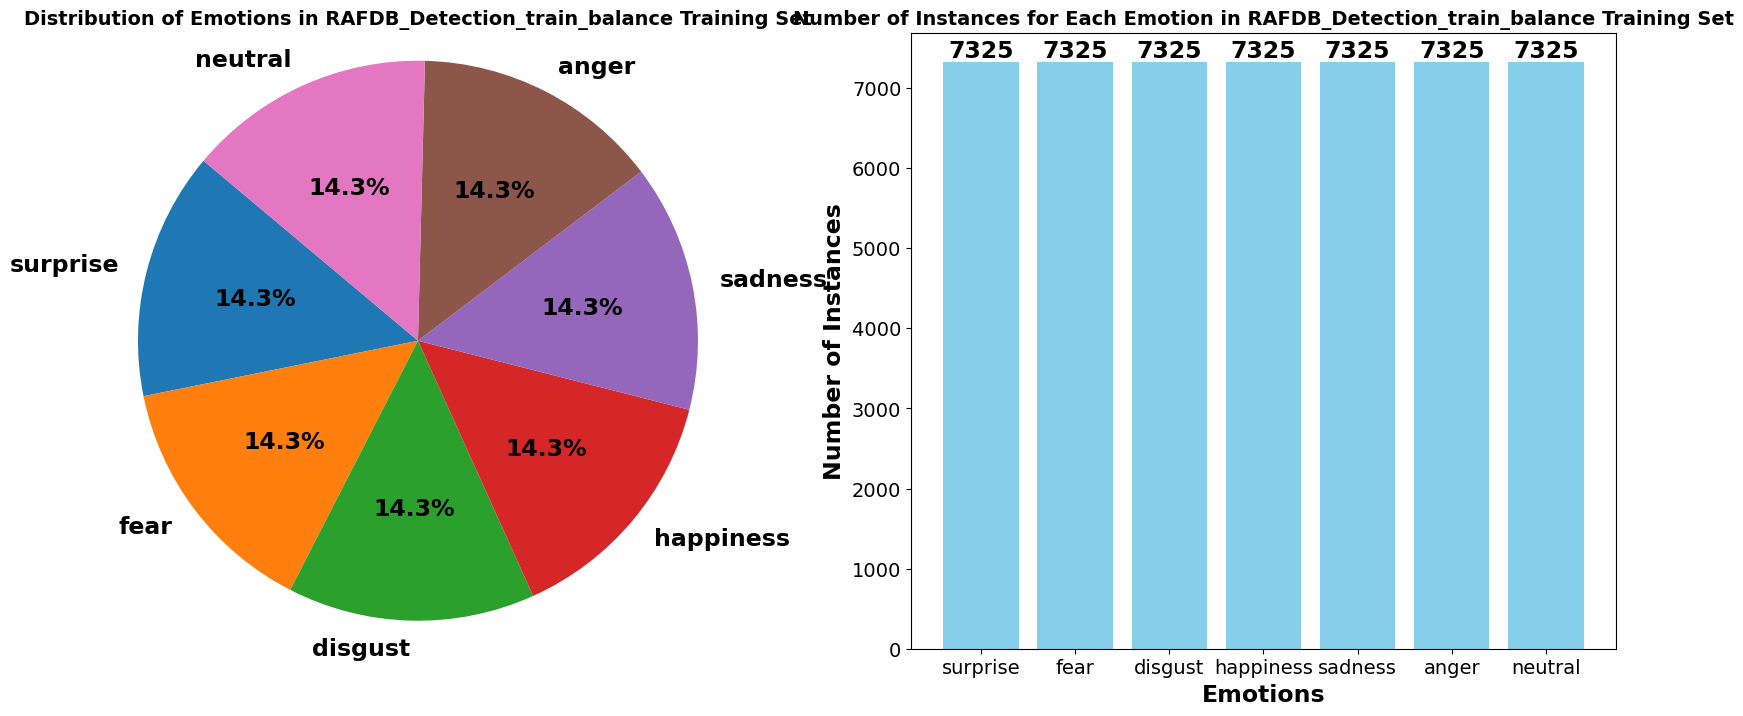

In [2]:
# RAFDB Training Set Dataset
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_train_balance/train'
dataset_name = 'RAFDB_Detection_train_balance Training Set'
analyze_yolo_dataset_total(dataset_path, dataset_name)

### Test label accuracy by output

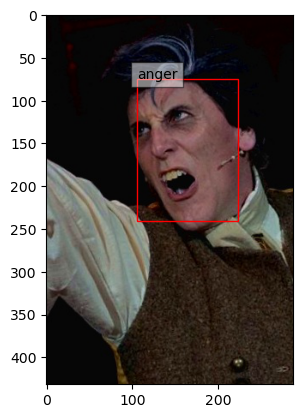

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

classes = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

image_path = r'/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_train_balance/train/images/anger_743_train_01012.jpg'
img = Image.open(image_path)
label_path = r'/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_train_balance/train/labels/anger_743_train_01012.txt'
with open(label_path, 'r') as f:
    labels = f.readlines()

fig, ax = plt.subplots(1)
ax.imshow(img)
width, height = img.size

for label in labels:
    parts = label.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * width
    y_center = float(parts[2]) * height
    bbox_width = float(parts[3]) * width
    bbox_height = float(parts[4]) * height
    
    xmin = x_center - bbox_width / 2
    ymin = y_center - bbox_height / 2
    
    rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmin, ymin, classes[class_id], bbox=dict(facecolor='white', alpha=0.5))

plt.show()